<a href="https://colab.research.google.com/github/Wenuka19/DermAI/blob/main/Colab/DermAI_Vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [ ]:
!pip install keras-vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tf.keras-vis tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 845 kB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from IPython.display import clear_output 
import wandb
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from wandb.keras import WandbCallback

from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator

from tf_keras_vis.saliency import Saliency
from vis.utils import utils

import seaborn as sns 
import pandas as pd
import sklearn.metrics

In [ ]:
!wandb login 0150b3d8e70b00c4b8b62cbf7c729ea59d224292

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
# # # # For toy model
# IMG_SIZE = (256,256)

IMG_SIZE = (224,224)

In [ ]:
# Load images from drive
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    fill_mode='nearest',
    zoom_range=[1.6, 1.6],
    brightness_range = [0.2,1.0] 
)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
# for X_batch, y_batch in train_datagen.flow_from_directory(train_data_dir, batch_size=9, shuffle=True,class_mode='categorical',target_size=IMG_SIZE):
#     # create a grid of 3x3 images
#     fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
#     for i in range(3):
#         for j in range(3):
#             ax[i][j].imshow(X_batch[i*3+j]/255)
#             ax[i][j].set_title(class_names[np.argmax(y_batch[i*3+j])])
#     # show the plot
#     plt.show()
#     break

If you are using TPU runtime, run the below cell

In [ ]:
# Connect to TPU
print("Tensorflow version " + tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.9.2
Running on TPU  ['10.16.208.162:8470']


If you are using GPU runtime, run the below cell to verify GPU allocation

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#copy data to memory. upload it as a zip file. create a folder called 'data' before executing

!cp '/content/drive/MyDrive/DermAI_Datasets/fitzpatrick17k/output.zip' '/content/data'

In [ ]:
# folder = "/content/drive/MyDrive/DermAI_Datasets/fitzpatrick17k/"
# !(cd ‘{folder}’ && zip -r -q splitted.zip splitted)
# !zip -r "/content/drive/MyDrive/DermAI_Datasets/fitzpatrick17k/data.zip" "/content/drive/MyDrive/DermAI_Datasets/fitzpatrick17k/splitted"

In [ ]:
train_data_dir= os.path.join('/content','data','output','train')
val_data_dir = os.path.join('/content','data','output','val')
test_data_dir = os.path.join('/content','data','output','test')

In [ ]:
data_dir1= os.path.join('/content','drive','MyDrive','DermAI_Datasets','fitzpatrick17k','splitted')

In [ ]:
# !unzip '/content/data/dataset.zip'
!unzip '/content/data/output.zip' -d '/content/data'
clear_output()

In [ ]:
 train_data = train_datagen.flow_from_directory(train_data_dir, batch_size=32, shuffle=False,class_mode='categorical',target_size=IMG_SIZE)
 val_data = val_datagen.flow_from_directory(val_data_dir, batch_size=32, shuffle=False,class_mode='categorical',target_size=IMG_SIZE)
 test_data = test_datagen.flow_from_directory(test_data_dir, batch_size=32, shuffle=False,class_mode='categorical',target_size=IMG_SIZE)

In [ ]:
#Load data as numpy arrays
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,label_mode='categorical',  image_size=IMG_SIZE,batch_size=32,)
val_data = tf.keras.utils.image_dataset_from_directory(val_data_dir,label_mode='categorical',  image_size=IMG_SIZE,batch_size=32,)
test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,label_mode='categorical',  image_size=IMG_SIZE,batch_size=32,)

Found 13212 files belonging to 114 classes.
Found 1612 files belonging to 114 classes.
Found 1753 files belonging to 114 classes.


In [ ]:
train_dataset = train_data.map(lambda x,y:(preprocess_input(x),y))
val_dataset = val_data.map(lambda x,y:(preprocess_input(x),y))
test_dataset = test_data.map(lambda x,y:(preprocess_input(x),y))

In [ ]:
train_dataset.cardinality().numpy()

413

In [ ]:
fist_5_data = train_data.as_numpy_iterator().next()[0][0]
fist_5_data_shape = train_data.as_numpy_iterator().next()[0].shape

first_5_labels = train_data.as_numpy_iterator().next()[1]
fist_5_labels_shape = train_data.as_numpy_iterator().next()[1].shape

print(fist_5_data)
print(fist_5_data_shape)
print(first_5_labels)
print(fist_5_labels_shape)

In [ ]:
class_names = train_data.class_names

In [ ]:
class_names = list(train_data.class_indices.keys())
print(class_names)

In [ ]:
for_test = train_dataset.as_numpy_iterator().next()

In [ ]:
xr = (np.argmax(for_test[1], axis=1))

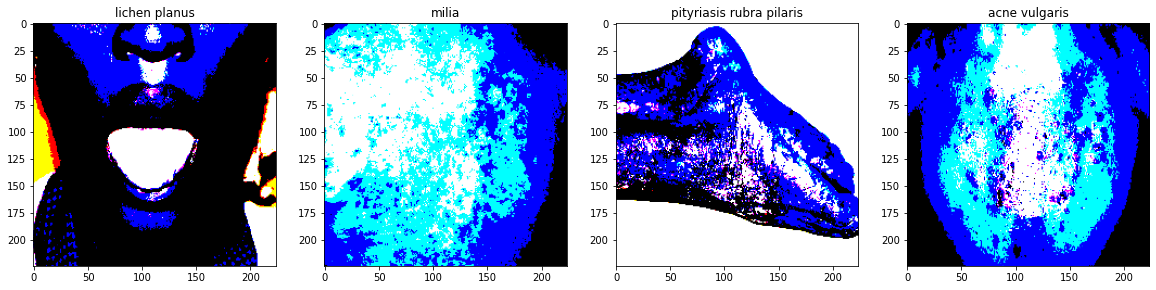

In [ ]:
#view some images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(for_test[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(class_names[xr[idx]])

In [ ]:
data_augmentation = Sequential(
    [layers.Resizing(256,256),
    #  layers.CenterCrop(224, 224),
    #  layers.RandomBrightness([-0.8,0.8]),
     layers.RandomContrast(0.2),
    #  layers.RandomFlip("horizontal",input_shape=IMG_SIZE),
     layers.RandomRotation(factor = 2)
     ]
)

## Toy model to set up a full training + evaluation skeleton

In [ ]:

tf.random.set_seed(1)

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3),padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu',padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu',padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu',padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
wandb.init(project="DermAI-01-Toy", save_code=True)
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=val_dataset,callbacks=[WandbCallback(save_model=False)])

In [ ]:
model.save_weights('toy_model1.h5')
wandb.save('toy_model1.h5')
wandb.finish()

accuracy,▁▁▂▃▄▆▇▇▇█████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,██▇▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▅▅▆▆▆▆▇▇▇▇▇▇██▇▇█▇████████
val_loss,▁▁▁▁▂▂▃▃▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
accuracy,0.98608
best_epoch,2
best_val_loss,4.01586
epoch,29
loss,0.05729
val_accuracy,0.3425


### Plot the results

In [ ]:
print(history.history)

{'loss': [4.466696262359619, 4.163534164428711, 3.695727825164795, 2.899256467819214, 1.9843436479568481, 1.2848020792007446, 0.838064968585968, 0.5879413485527039, 0.40867990255355835, 0.3115273118019104, 0.24348819255828857, 0.19262570142745972, 0.15336157381534576, 0.14489968121051788, 0.1374637335538864, 0.13502252101898193, 0.11681989580392838, 0.09940679371356964, 0.10458267480134964, 0.09714101254940033, 0.07292728871107101, 0.09826897084712982, 0.07816560566425323, 0.07874078303575516, 0.06642526388168335, 0.07691936939954758, 0.05698737874627113, 0.060490526258945465, 0.05592220649123192, 0.05728888139128685], 'accuracy': [0.048046037554740906, 0.08505085855722427, 0.1621386557817459, 0.3197939097881317, 0.515256941318512, 0.6855594515800476, 0.7911536693572998, 0.8559957146644592, 0.8968816995620728, 0.9259903430938721, 0.9385706782341003, 0.9522885680198669, 0.9620583653450012, 0.9651365280151367, 0.9652034044265747, 0.9668763279914856, 0.9737687110900879, 0.9775829911231995

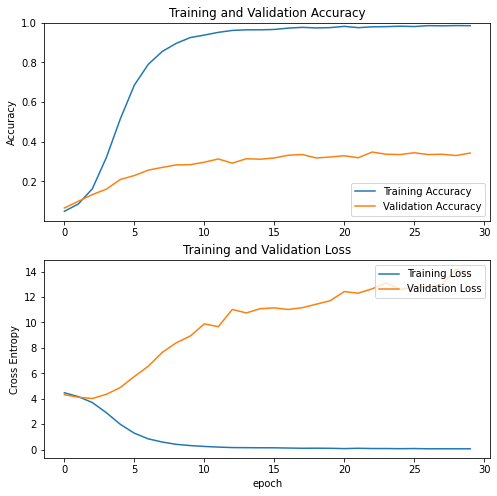

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_data_scaled)
print('Test accuracy :', accuracy)

25/25 [==============================] - 49s 78ms/step - loss: 1.5324 - accuracy: 0.9100
Test accuracy : 0.9100000262260437


In [ ]:
labels = []
predictions = []

for x, y in train_data_scaled:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

confusion_matrix = sklearn.metrics.confusion_matrix(
    labels,
    predictions
)

df_cm = pd.DataFrame(confusion_matrix,index = class_names,columns=class_names)

In [ ]:
df_cm

In [ ]:
plt.figure(figsize = (50,35))
sns.heatmap(confusion_matrix, annot=True)

In [ ]:
# Try doing a sample prediction
import matplotlib.image as mpimg
img = mpimg.imread('/content/sample_data/img04.jpg')
resized_img = img.resize(256,256)
imgplot = plt.imshow(resized_img)
plt.show()

In [ ]:
# Imports PIL module 
from PIL import Image

img = Image.open('/content/sample_data/img04.jpg')
resized_img = np.array(img.resize((256, 256)), dtype=np.uint8)
scaled_img = np.expand_dims(resized_img/255, axis=0)
imgplot = plt.imshow(resized_img)
plt.show()
class_names[np.argmax(model.predict(scaled_img))]

In [ ]:
# Try reloading the model
best_model = wandb.restore('toy_model1.h5', run_path="Wenuka_19/DermAI-01-Toy/zg99acwi")
model.load_weights(best_model.name)


In [ ]:
history = model.fit(train_data_scaled,
wandb.init(project="DermAI-01-Toy", save_code=True)
history = model.fit(train_data_scaled,
                    epochs=5,
                    validation_data=validation_data_scaled,callbacks=[WandbCallback(save_model=False)])


In [ ]:
model.save_weights('toy_model1.h5')
wandb.save('toy_model1.h5')
wandb.finish()

## Start of proper model

In [ ]:
def create_model(input_shape, n_classes, optimizer='adam', fine_tune=0):
    conv_base = VGG16(include_top=True,weights='imagenet',input_shape=input_shape)
    model = Sequential()
    
    if fine_tune > 0:
      for layer in conv_base.layers[:-fine_tune]:
        layer.trainable = False
    else:
      for layer in conv_base.layers:
        layer.trainable = False

    for layer in conv_base.layers[:-1]:
      model.add(layer)   
    model.add(Dense(256, activation='relu'))
    # model.add(Dense(512, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    # model = Model(inputs=conv_base.input, outputs=conv_base.output)

    # Compiles the model for training.
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
n_classes = len(class_names)

In [ ]:
base_learning_rate = 0.01
optim_1 = Adam(learning_rate=base_learning_rate)
vgg_model = create_model(IMG_SHAPE, n_classes, optim_1, fine_tune=0)

In [ ]:
vgg_model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [ ]:
tf.keras.utils.plot_model(vgg_model, to_file='model.png', show_shapes=True, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=72,layer_range=None, show_layer_activations=False)

In [ ]:
vgg_model.summary()

In [ ]:
initial_epochs = 30

In [ ]:
config = {"Name":"Model on the paper","lr": 0.1, "batch_size": 32,"new_model":True}

wandb.init(project="DermAI-01", save_code=True,config=config)
callback =  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8)
history = vgg_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset,callbacks=[WandbCallback(save_model=False),callback])

accuracy,▁▂▄█
epoch,▁▃▆█
loss,█▆▄▁
val_accuracy,▄█▄▁
val_loss,▂▁▃█
accuracy,0.23418
best_epoch,1
best_val_loss,4.28316
epoch,3
loss,3.27086
val_accuracy,0.04963


Epoch 1/30
413/413 [==============================] - 86s 203ms/step - loss: 4.0263 - accuracy: 0.1293 - val_loss: 3.6582 - val_accuracy: 0.1749
Epoch 2/30
413/413 [==============================] - 82s 197ms/step - loss: 3.1775 - accuracy: 0.2479 - val_loss: 3.5007 - val_accuracy: 0.2072
Epoch 3/30
413/413 [==============================] - 86s 207ms/step - loss: 2.6899 - accuracy: 0.3410 - val_loss: 3.5273 - val_accuracy: 0.2227
Epoch 4/30
413/413 [==============================] - 81s 195ms/step - loss: 2.3156 - accuracy: 0.4172 - val_loss: 3.5271 - val_accuracy: 0.2463
Epoch 5/30
413/413 [==============================] - 83s 200ms/step - loss: 1.9820 - accuracy: 0.4921 - val_loss: 3.6226 - val_accuracy: 0.2432
Epoch 6/30
413/413 [==============================] - 82s 196ms/step - loss: 1.6965 - accuracy: 0.5535 - val_loss: 3.7103 - val_accuracy: 0.2618
Epoch 7/30
413/413 [==============================] - 83s 199ms/step - loss: 1.4354 - accuracy: 0.6202 - val_loss: 3.8757 - val_ac

In [ ]:
vgg_model.save_weights('model1.h5')
wandb.save('model1.h5')
wandb.finish()

accuracy,▁▂▃▄▅▆▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▆▆▇▇█▇▇
val_loss,▂▁▁▁▂▃▄▄▆█
accuracy,0.76922
best_epoch,1
best_val_loss,3.5007
epoch,9
loss,0.86504
val_accuracy,0.26737


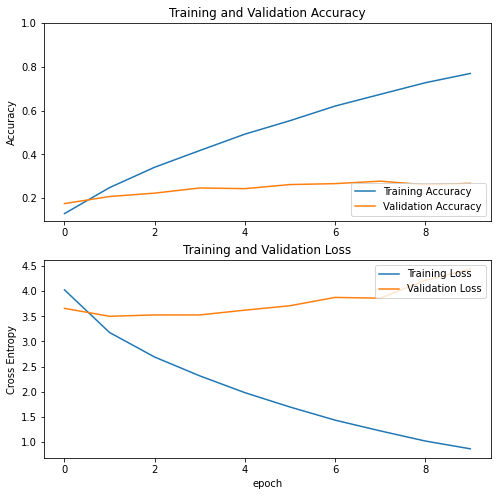

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Try reloading the model
best_model = wandb.restore('model1.h5', run_path="Wenuka_19/DermAI-01/snbmrax4")
vgg_model.load_weights(best_model.name)

### Evaluate the model

In [ ]:
labels = []
predictions = []

for x, y in test_dataset:
  predictions = np.concatenate([predictions, np.argmax(vgg_model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

1/1 [==============================] - 3s 3s/step


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

accuracy = accuracy_score(labels, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(labels, predictions,average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(labels, predictions,average='macro')
print('Recall: %f' % recall)


Accuracy: 0.282373
Precision: 0.321058
Recall: 0.254009


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
loss, accuracy = vgg_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

55/55 [==============================] - 10s 170ms/step - loss: 4.5246 - accuracy: 0.2824
Test accuracy : 0.2823730707168579


# Fine Tuning

In [ ]:
fine_tune_from=15
for layer in vgg_model.layers[fine_tune_from:]:
  layer.trainable = True

In [ ]:
# double check 
for l in vgg_model.layers:
  print(l.trainable)

In [ ]:
new_lr = base_learning_rate/100
new_optim = Adam(learning_rate=new_lr)
vgg_model.compile(optimizer=new_optim, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
config = {"lr": 0.0001, "batch_size": 32,"vgg_16_normalized":True,"Note":"Fine tuned. Trained from 15 onwards. First train after fine tuning"}
new_epochs = 10
wandb.init(project="DermAI-01", save_code=True,config=config)
callback =  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8)
history = vgg_model.fit(train_data,
                    epochs=new_epochs,
                    validation_data=val_data,callbacks=[callback,WandbCallback(save_model=False)])

# Visualization

In [ ]:
# Imports PIL module 
from PIL import Image

img = Image.open('/content/sample_data/67.jpg')
resized_img = np.array(img.resize(IMG_SIZE), dtype=np.uint8)
scaled_img = np.expand_dims(preprocess_input(resized_img), axis=0)
imgplot = plt.imshow(resized_img)
plt.show()
class_names[np.argmax(vgg_model.predict(scaled_img))]

In [ ]:
import seaborn as sns 

confusion_matrix = tf.math.confusion_matrix(
    labels,
    predictions,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)


In [ ]:
print(len(labels))
print(predictions)

1753
[86. 98. 98. ... 51. 68. 59.]


In [ ]:
plt.figure(figsize = (50,50))
sns.heatmap(confusion_matrix, annot=True)

# Convert the Model

In [ ]:
!rm -rf '/content/data/output'

In [ ]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(vgg_model)
converter.target_spec.supported_ops = [
                tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
                tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
            ]
tfmodel = converter.convert()
 
open('vgg_model.tflite', 'wb').write(tfmodel)

# Test the Tflite model performance

In [ ]:
# Load the tflite model
tf_lite_model = tf.lite.Interpreter(model_path="tf_lite01.tflite")

In [ ]:
tf_lite_model.evaluate_tflite('tf_lite01.tflite', test_dataset)

# GRAD CAM + Saliency

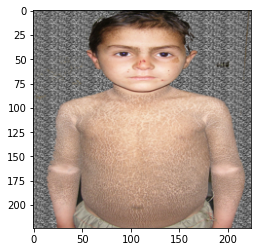

In [ ]:
# Imports PIL module 
from PIL import Image

input_image = Image.open('/content/sample_data/73.jpg')
resized_img = np.array(input_image.resize(IMG_SIZE), dtype=np.uint8)
scaled_img = np.expand_dims(preprocess_input(resized_img), axis=0)
imgplot = plt.imshow(resized_img)
plt.show()

In [ ]:
vgg_model.layers[-1].activation = tf.keras.activations.linear
model = utils.apply_modifications(vgg_model)

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore
class_index = np.argmax(vgg_model.predict(scaled_img))
prediction = class_names[class_index]
print(prediction)
score = CategoricalScore([class_index])

1/1 [==============================] - 0s 19ms/step
pityriasis rubra pilaris


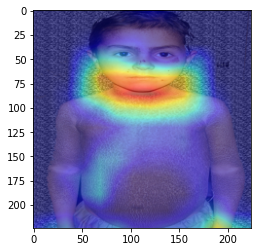

In [ ]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(model,clone=True)
cam = gradcam(score,scaled_img,penultimate_layer=-1)
heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
plt.imshow(resized_img)
plt.imshow(heatmap[0],cmap='jet', alpha=0.5)